In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
! pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: qasimbayramov
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:17<00:00, 144MB/s]


In [4]:
# Etiketler ve görüntü boyutu
labels = ["PNEUMONIA", "NORMAL"]
img_size = 150  # Görüntü boyutu 150x150

# Veriyi yüklemek için fonksiyon
def get_training_data(data_dir):
    data = []
    for label in labels:  # Etiketler: "PNEUMONIA" ve "NORMAL"
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # Etiket numarası: PNEUMONIA -> 0, NORMAL -> 1
        for img in tqdm(os.listdir(path)):  # Dizindeki tüm görüntüleri döngüyle işle
            try:
                # Görüntüyü gri ölçekli olarak oku
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:  # Eğer görüntü okunamazsa hata mesajı ver
                    print(f"Read image error: {img}")
                    continue

                # Görüntüyü yeniden boyutlandır
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Veriyi listeye ekle
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    return np.array(data, dtype=object)

base_dir = '/content/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

print(f"Train data shape: {len(train)}")
print(f"Test data shape: {len(test)}")
print(f"Validation data shape: {len(val)}")


100%|██████████| 8/8 [00:00<00:00, 130.43it/s]

Train data shape: 5216
Test data shape: 624
Validation data shape: 16


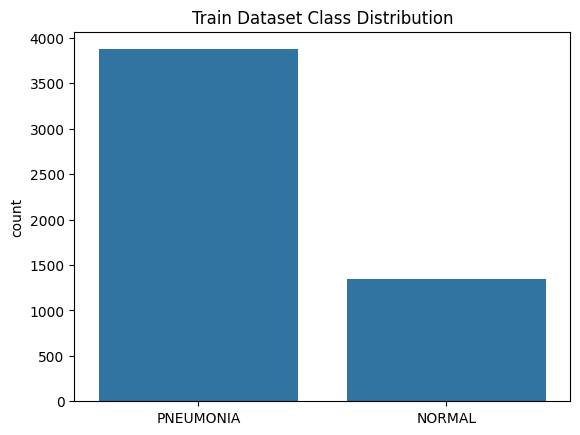

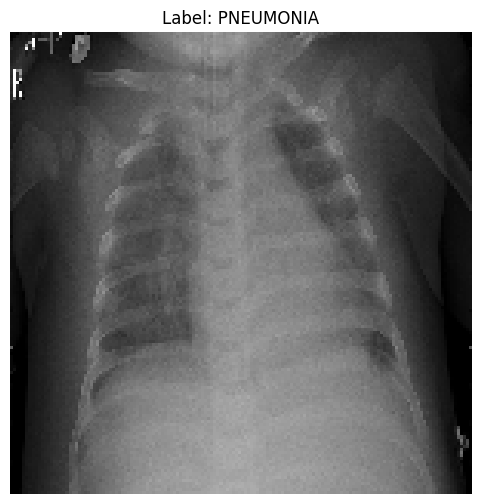

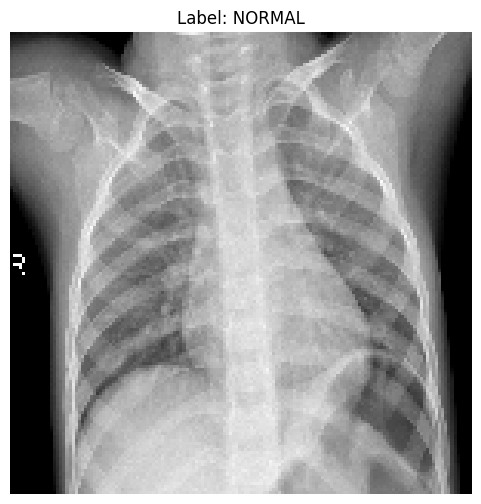

In [5]:
# Etiketleri belirle ve veri dağılımını görselleştir
labels_count = ["PNEUMONIA" if i[1] == 0 else "NORMAL" for i in train]
sns.countplot(x=labels_count)
plt.title("Train Dataset Class Distribution")
plt.show()

# Eğitim, test ve doğrulama setlerini ayır
x_train, y_train = zip(*train)  # Özellik ve etiketleri ayır
x_test, y_test = zip(*test)
x_val, y_val = zip(*val)

# Listeleri numpy array'e dönüştür (isteğe bağlı)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

# Görselleri ve etiketleri incelemek için örnek görselleştirme
plt.figure(figsize=(6, 6))
plt.imshow(train[0][0], cmap="gray")  # İlk görsel
plt.title(f"Label: {labels[train[0][1]]}")
plt.axis("off")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(train[-1][0], cmap="gray")  # Son görsel
plt.title(f"Label: {labels[train[-1][1]]}")
plt.axis("off")
plt.show()


In [6]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_test= np.array(y_test)
y_val = np.array(y_val)


In [9]:
# veri arttirimi
datagen = ImageDataGenerator(
    featurewise_center = False, # veri setinin genel ortalamasini 0 yapar
    samplewise_center = False, # her bir ornegin ortalamasini 0 yapar
    featurewise_std_normalization = False, # veriyi verinin std bolme
    samplewise_std_normalization = False, # her bir ornegi kendi std sapmasina bolme islemi
    zca_whitening=False, # zca beyazlatma yontemi, korelasyonu azaltma
    rotation_range = 30, # resimleri x derece rasgele dondurur
    zoom_range = 0.2, # rasgele yakinlastirma isleme
    width_shift_range = 0.1, # yatay olarak rasgele kaydirma
    height_shift_range = 0.1, # resimleri dikey olarak rasgele kaydirir
    horizontal_flip = True, # resimleri rasgele yatay olarak cevirir
    vertical_flip = True # resimleri rasgele dikey olarak cevirir
    )
datagen.fit(x_train)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 128)       │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 150, 150, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 38, 38, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 38, 38, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 11552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,478,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,537 (6.52 MB)

 Trainable params: 1,709,089 (6.52 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.7894 - loss: 0.8121 - val_accuracy: 0.6779 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.8797 - loss: 0.2776 - val_accuracy: 0.6250 - val_loss: 6.0677 - learning_rate: 0.0010
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8967 - loss: 0.2508
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.8967 - loss: 0.2508 - val_accuracy: 0.6250 - val_loss: 16.8046 - learning_rate: 0.0010
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9094 - loss: 0.2265 - val_accuracy: 0.6250 - val_loss: 17.5445 - learning_rate: 5.0000e-04
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9169 - loss: 0.2175
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9

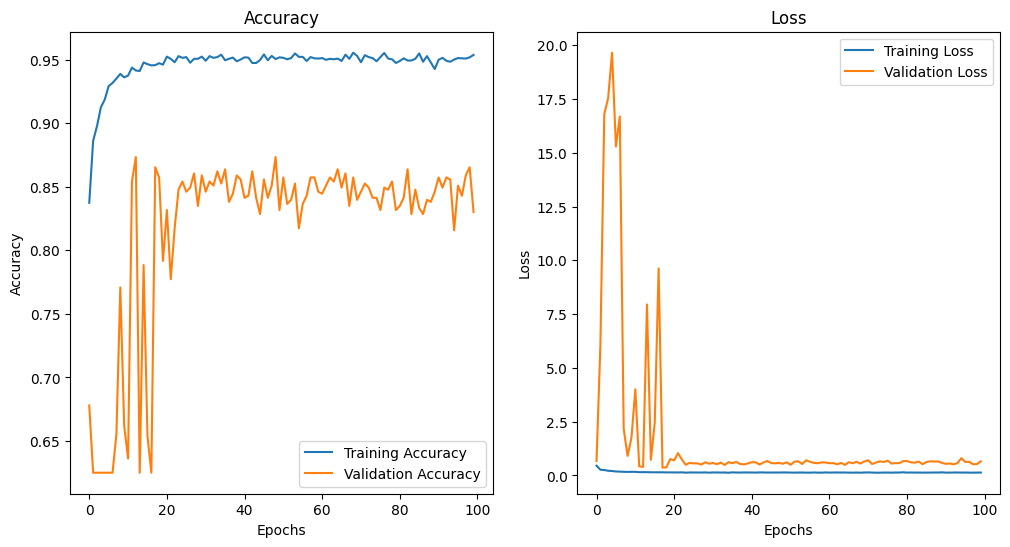

In [10]:
# Model Tanımı
model = Sequential()

# 1. Convolutional Katmanı
model.add(Conv2D(128, (7, 7), strides=1, padding="same", activation="relu", input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

# 2. Convolutional Katmanı
model.add(Conv2D(64, (5, 5), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout oranı artırıldı
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

# 3. Convolutional Katmanı
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.3))  # Dropout oranı artırıldı

# Çıkış Katmanı
model.add(Dense(units=1, activation="sigmoid"))

# Modelin Derlenmesi
optimizer = Adam(learning_rate=0.001)  # RMSprop yerine Adam kullanıldı
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Learning Rate Azaltıcı Callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    factor=0.5,  # Learning rate azaltma faktörü artırıldı
    min_lr=1e-6
)

# Modelin Eğitimi
epoch_number = 100
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=epoch_number,
    validation_data=datagen.flow(x_test, y_test),
    callbacks=[learning_rate_reduction]
)

# Modelin Değerlendirilmesi
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Loss of Model: {loss:.4f}")
print(f"Accuracy of Model: {accuracy * 100:.2f}%")

# Eğitim ve Doğrulama Performansı Grafiği
epochs = range(epoch_number)
plt.figure(figsize=(12, 6))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="Training Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [24]:
import os
import matplotlib.pyplot as plt
from PIL import Image


epochs = 100
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

output_dir = "/content/epoch_visuals_accuracy"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(epochs):
    plt.figure(figsize=(8, 6))

    # Kayıp grafiği
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epoch + 2), train_loss[:epoch + 1], label='Train Loss', marker='o')
    plt.plot(range(1, epoch + 2), val_loss[:epoch + 1], label='Validation Loss', marker='o')
    plt.title(f"Training Loss Progress (Epoch {epoch + 1}/{epochs})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()


    plt.subplot(2, 1, 2)
    plt.plot(range(1, epoch + 2), train_acc[:epoch + 1], label='Train Accuracy', marker='o')
    plt.plot(range(1, epoch + 2), val_acc[:epoch + 1], label='Validation Accuracy', marker='o')
    plt.title(f"Training Accuracy Progress (Epoch {epoch + 1}/{epochs})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"epoch_{epoch + 1}_progress.png")) # Görseli kaydet
    plt.close()

from PIL import Image
import imageio

gif_path = "/content/training_progress_1.gif"
images = [Image.open(os.path.join(output_dir, f"epoch_{i + 1}_progress.png")) for i in range(epochs)]
imageio.mimsave(gif_path, [np.array(img) for img in images], fps=1)

print(f"GIF oluşturuldu: {gif_path}")

from google.colab import files
files.download(gif_path)

GIF oluşturuldu: /content/training_progress_1.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import imageio
from IPython.display import Image

Image(filename="/content/training_progress_1.gif")

imageio.mimsave(gif_path, images, fps=10) # Adjust fps for speed


<ipython-input-32-549883999fb3>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


GIF oluşturuldu: /content/training_progress_final.gif


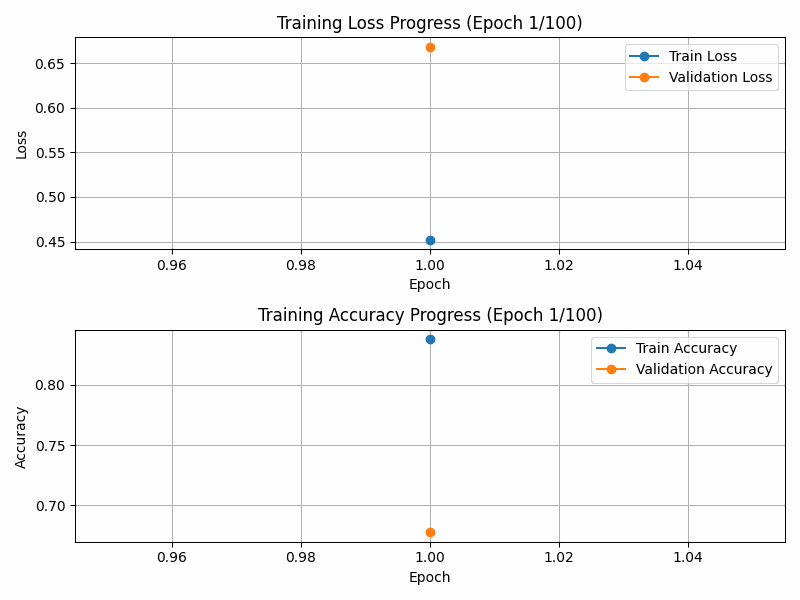

In [32]:
import imageio
import os
from IPython.display import Image

gif_path = "/content/training_progress_final.gif"
images = []
for i in range(1, 101):
    try:
        image_path = f"/content/epoch_visuals_accuracy/epoch_{i}_progress.png"
        images.append(imageio.imread(image_path))
    except FileNotFoundError:
        print(f"Warning: Image file not found at {image_path}. Skipping.")

imageio.mimsave(gif_path, images, fps=10, loop=0)

print(f"GIF oluşturuldu: {gif_path}")

Image(filename=gif_path)

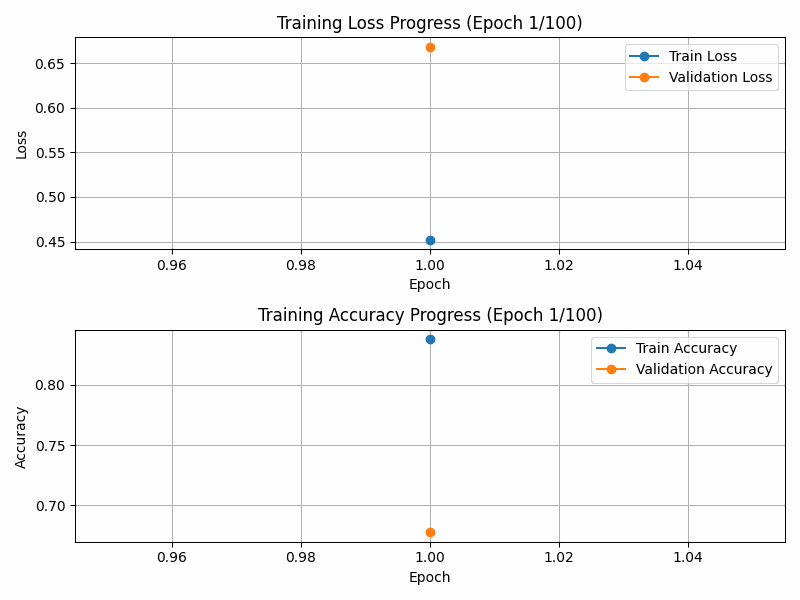

In [33]:
from IPython.display import Image

Image(filename="/content/training_progress_final.gif")

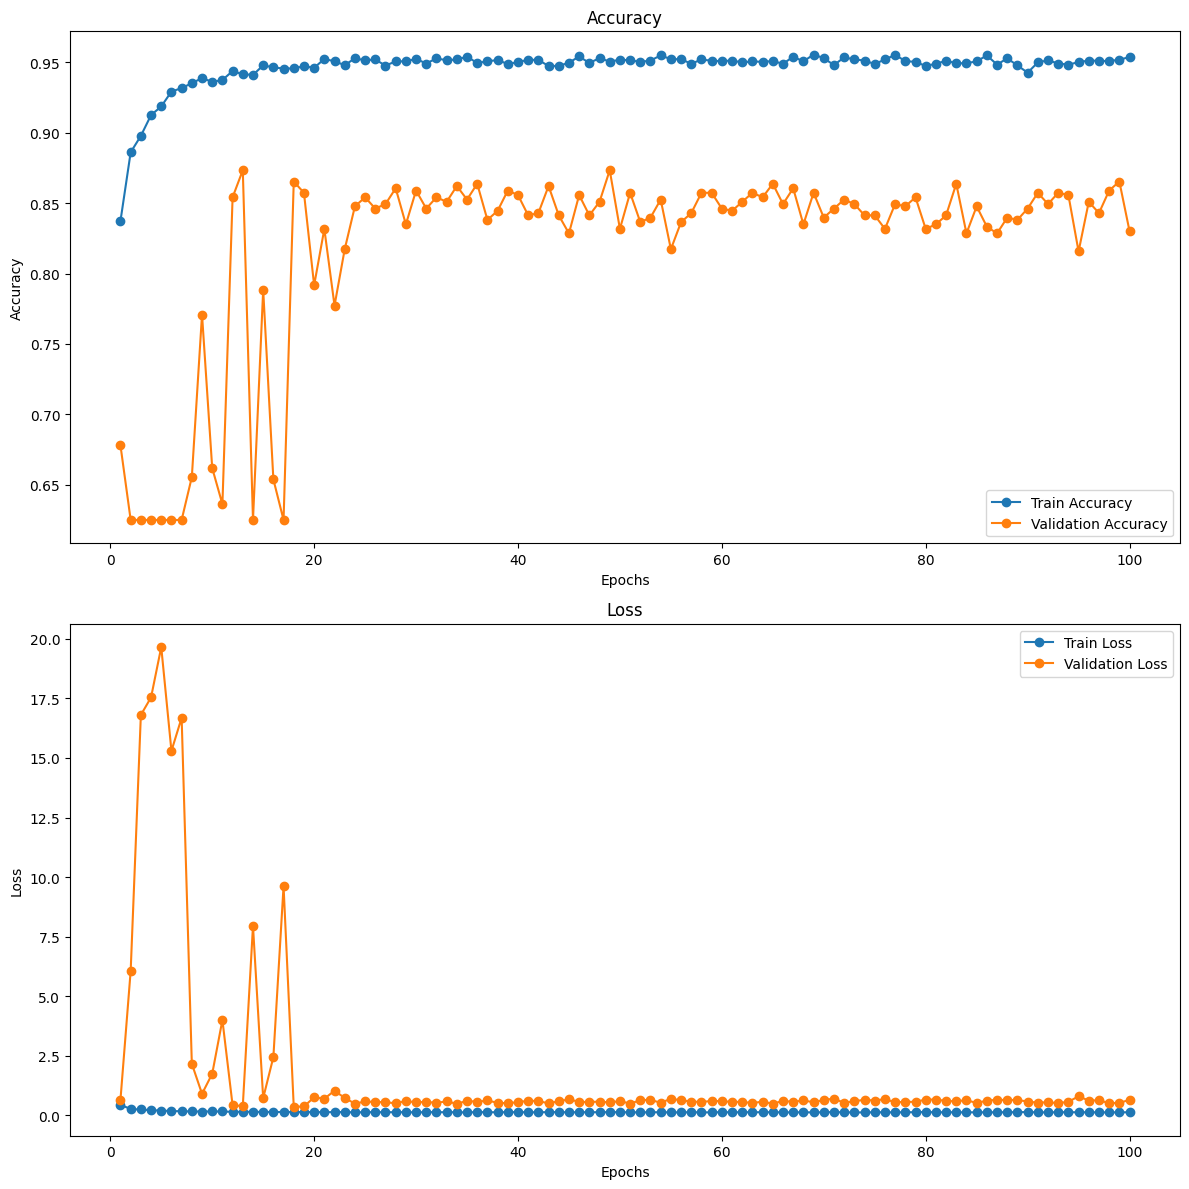

In [35]:
plt.figure(figsize=(12, 12))

# Accuracy Grafiği
plt.subplot(2, 1, 1)
plt.plot(range(1, epoch + 2), train_acc[:epoch + 1], label='Train Accuracy', marker='o')
plt.plot(range(1, epoch + 2), val_acc[:epoch + 1], label='Validation Accuracy', marker='o')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Grafiği
plt.subplot(2, 1, 2)
plt.plot(range(1, epoch + 2), train_loss[:epoch + 1], label='Train Loss', marker='o')
plt.plot(range(1, epoch + 2), val_loss[:epoch + 1], label='Validation Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


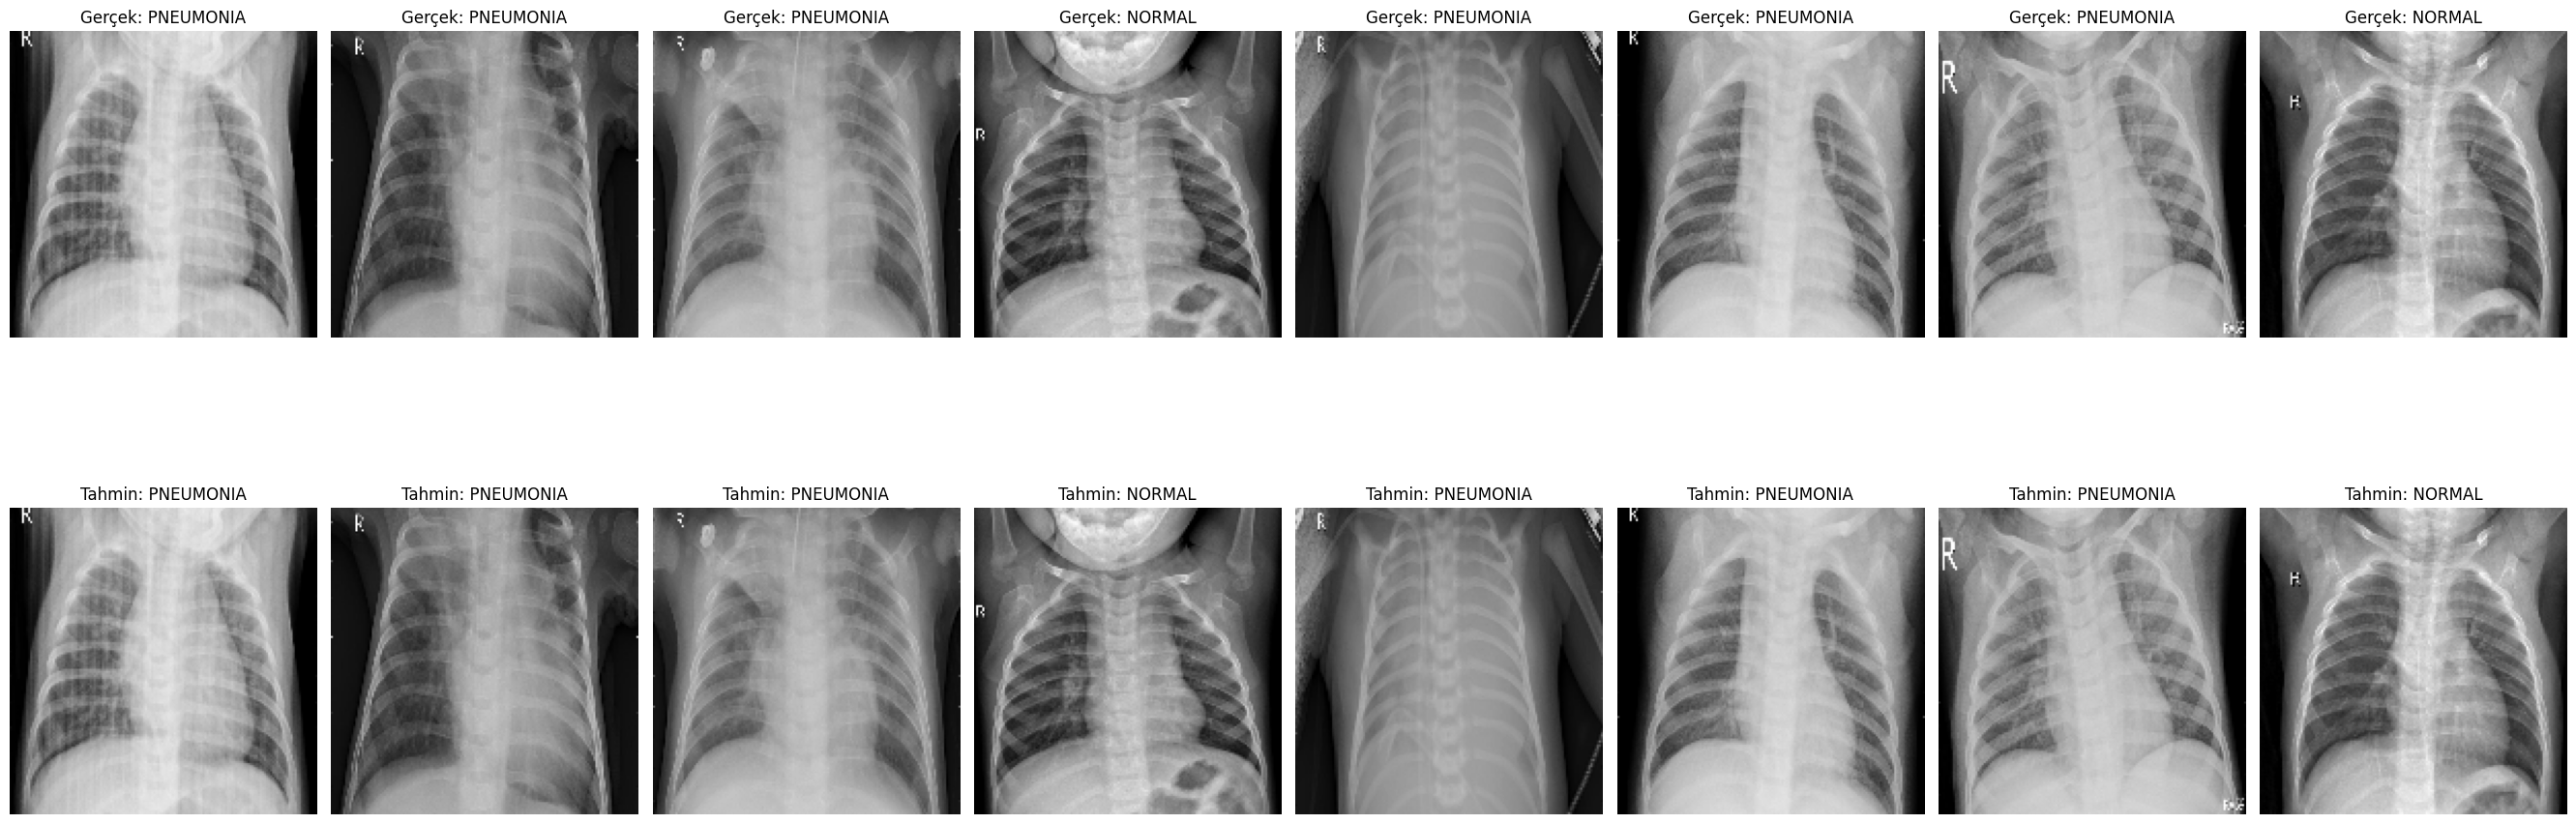

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import random

random_indices = random.sample(range(len(x_train)), 8)
random_real_images = [x_train[idx] for idx in random_indices]
random_real_labels = [y_train[idx] for idx in random_indices]

# Tahmin edilen etiketleri hesapla
predicted_labels = model.predict(np.array(random_real_images).reshape(-1, img_size, img_size, 1))
predicted_classes = [1 if pred > 0.5 else 0 for pred in predicted_labels]

# Görselleri çiz
plt.figure(figsize=(50, 10))

# Üst sırada gerçek görüntüler
for i, (real_image, real_label) in enumerate(zip(random_real_images, random_real_labels)):
    plt.subplot(2, 15, i + 1)
    plt.imshow(real_image.reshape(img_size, img_size), cmap="gray")
    plt.title(f"Gerçek: {labels[real_label]}")
    plt.axis("off")

# Alt sırada tahmin edilen görüntüler
for i, (real_image, pred_class) in enumerate(zip(random_real_images, predicted_classes)):
    plt.subplot(2, 15, i + 16)  # Sonraki 15 hücre (alt sıra)
    plt.imshow(real_image.reshape(img_size, img_size), cmap="gray")
    plt.title(f"Tahmin: {labels[pred_class]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
